# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import scipy.optimize as opt
import os
import glob
from scipy.stats import norm
import math
from scipy.stats import expon
import arviz as az
import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define functions

In [3]:
def UniqueVals(stims, responses):
    
    """
    Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [4]:
def nloglik(params,X,N,K):
    '''
    This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    '''   
    alpha=params[0]
    beta=params[1]
    
    psi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))

    nll = -ll
    
    return nll

In [5]:
def Fit_psi(stims, responses, Num_Inits):
    
    
    #Calculate unique values of the stims
    unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

    temp_ll = []
    temp_params = np.empty((Num_Inits,2))
    for i in range(Num_Inits):
        x0 = [np.random.randint(-30, 30), np.random.randint(0, 30)]
        
        res = opt.minimize(nloglik, x0=x0, args=(unique_stims,Nstims,Kleft),
                method='Nelder-Mead', bounds=((-50,50),(0,50)), options={'disp': False})
        
        temp_ll = np.append(temp_ll, res.fun)
        temp_params[i,:] = res.x
        
    min_idx = np.nanargmin(temp_ll)
    best_params = temp_params[min_idx]
    best_ll = temp_ll[min_idx]
    
    return best_params, best_ll

# Load the data

In [3]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_Constants')

#Load the data and combine
file_names = glob.glob("*.csv")
combined_data = [pd.read_csv(i) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

In [6]:
for name, test in grp_tests:
    
    #Calculate the percept of start positions that started above
    started_above = sum(test.AllStarts >= test.AllStims)
    above_prct = round((started_above/len(test))*100,1)

    #Print the results
    print(name[0]+name[1])
    print(str(above_prct) + '% of trials started above the stimulus position')

AFCdata_10a
50.0% of trials started above the stimulus position
AFCdata_10b
50.0% of trials started above the stimulus position
AFCdata_11a
50.0% of trials started above the stimulus position
AFCdata_11b
50.0% of trials started above the stimulus position
AFCdata_12a
50.0% of trials started above the stimulus position
AFCdata_12b
50.0% of trials started above the stimulus position
AFCdata_13a
50.0% of trials started above the stimulus position
AFCdata_13b
50.0% of trials started above the stimulus position
AFCdata_14a
50.0% of trials started above the stimulus position
AFCdata_14b
50.0% of trials started above the stimulus position
AFCdata_20a
50.0% of trials started above the stimulus position
AFCdata_20b
50.0% of trials started above the stimulus position
AFCdata_21a
50.0% of trials started above the stimulus position
AFCdata_21b
50.0% of trials started above the stimulus position
AFCdata_22a
50.0% of trials started above the stimulus position
AFCdata_22b
50.0% of trials started abov

# Data Analysis 

## Plot each test

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))


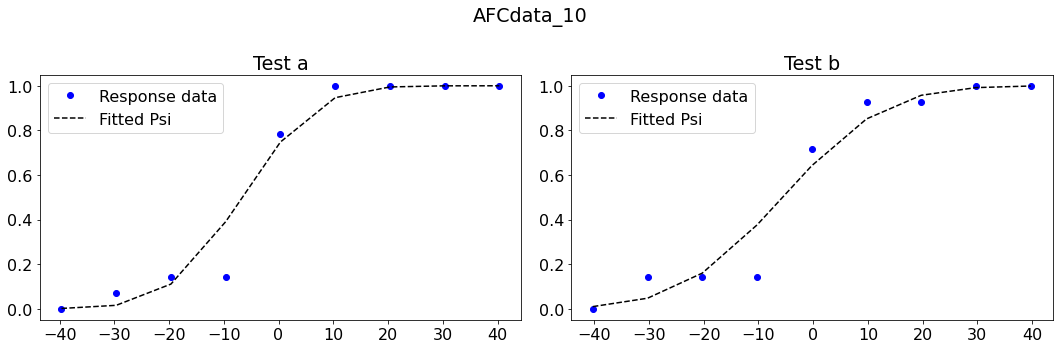

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: Runti

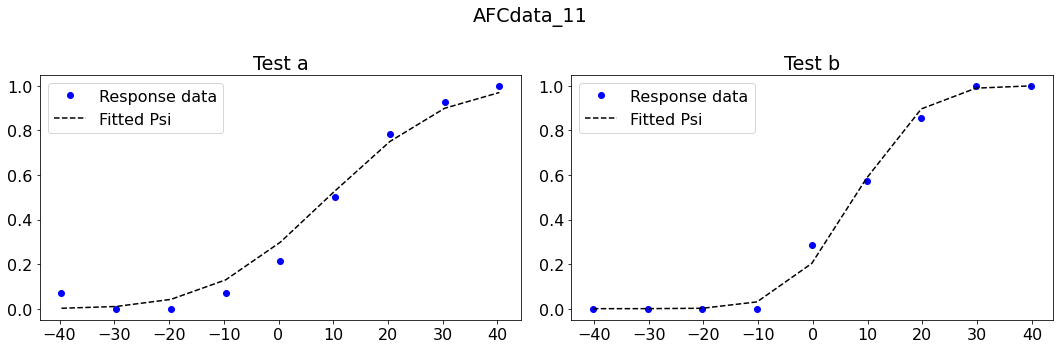

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


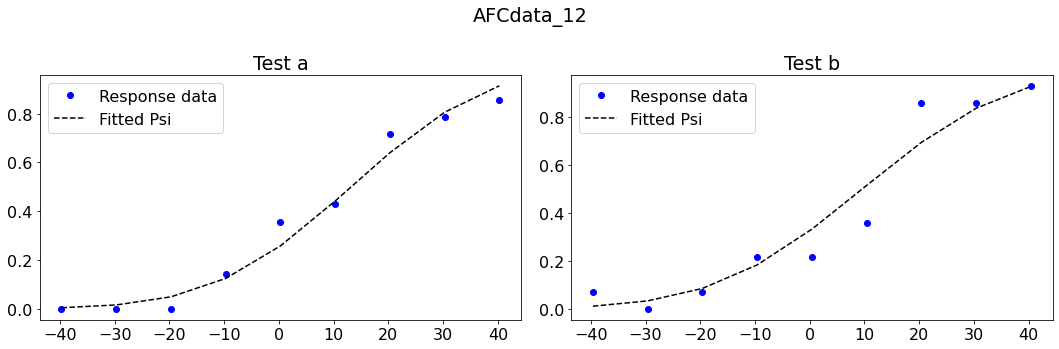

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:19

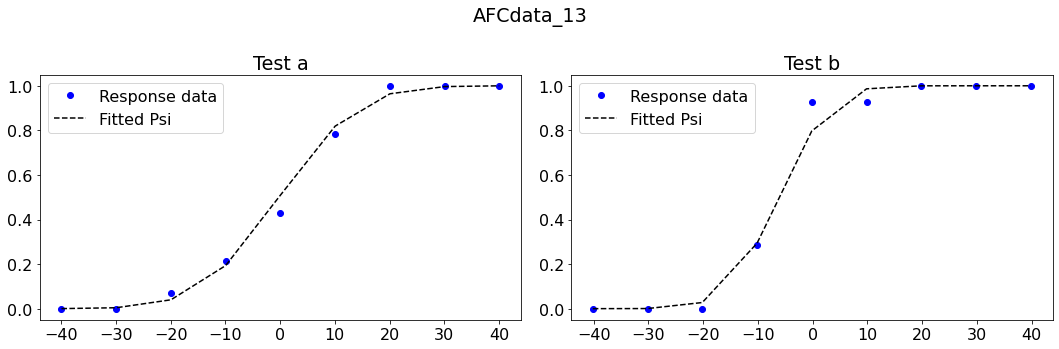

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))


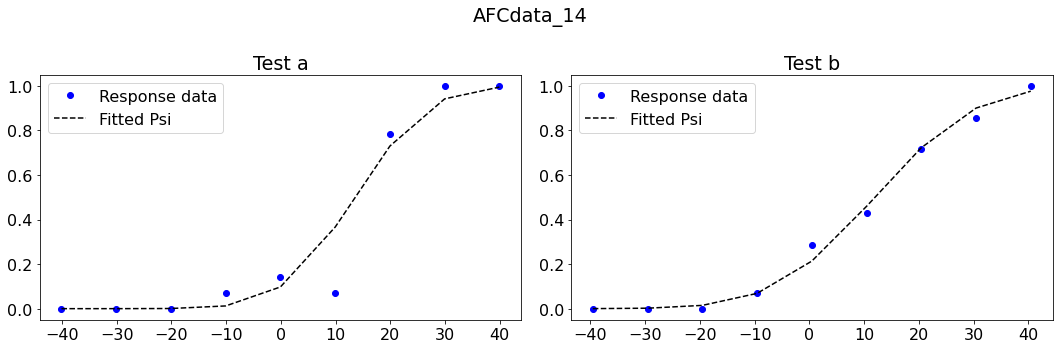

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


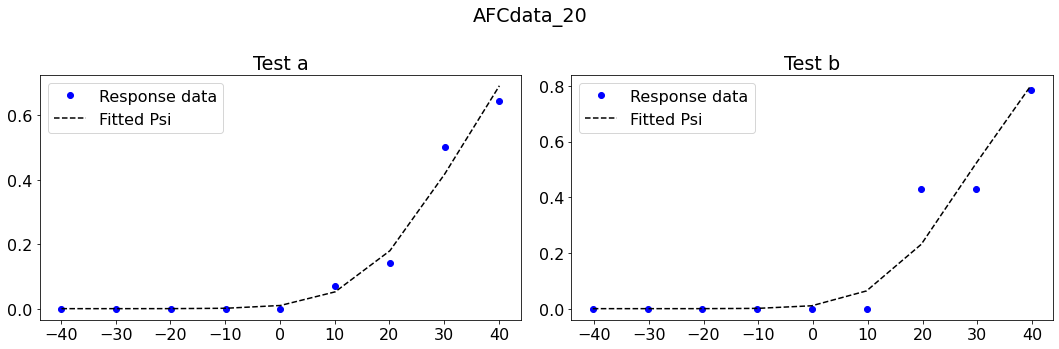

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:19

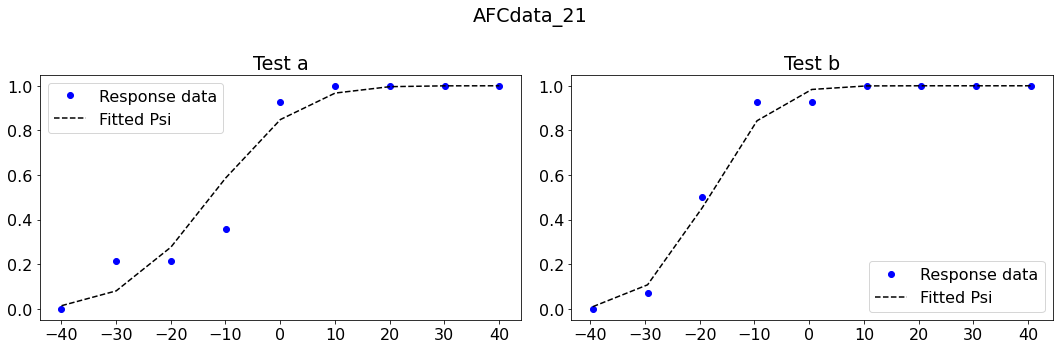

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: Runti

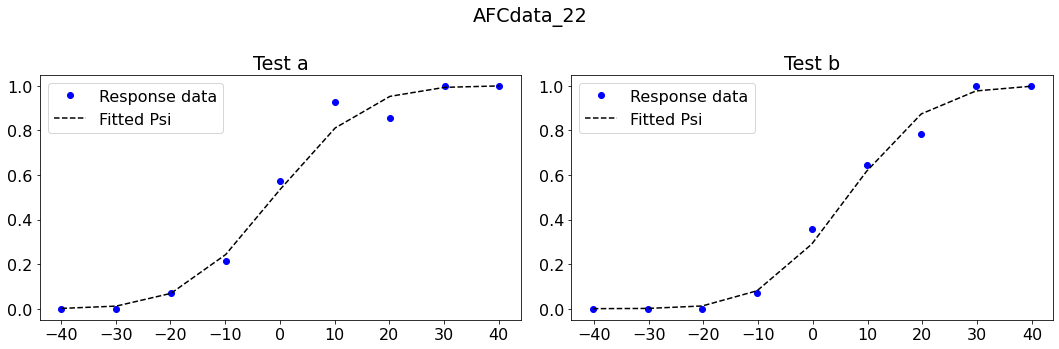

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


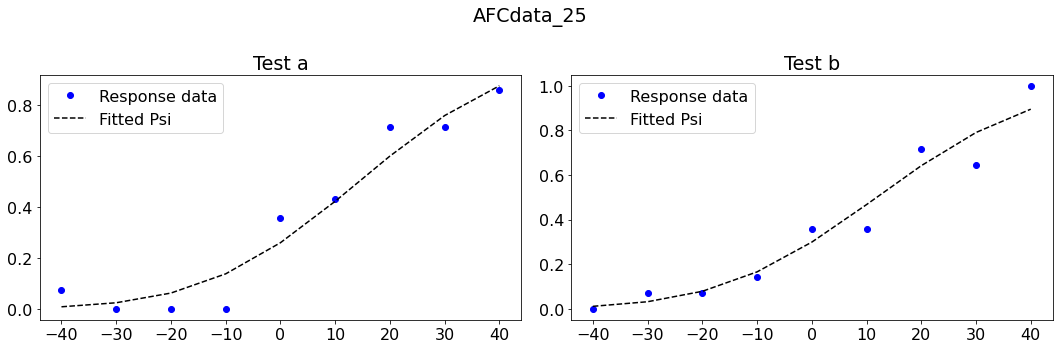

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_11480/3348825091.py:13: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(K * np.log(psi) + ((N - K) * np.log(1-psi)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWa

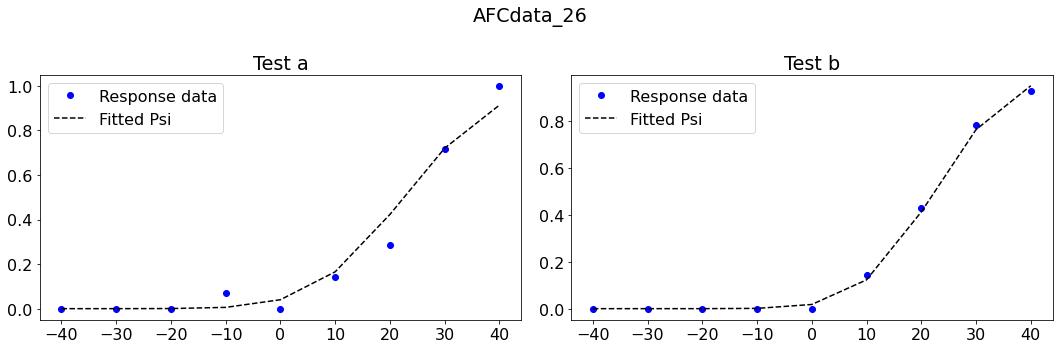

In [7]:
unique_tests = ['a','b']
AIC_diff = []
fit_alphas, fit_betas = np.empty((len(grp_subjs),len(unique_tests))), np.empty((len(grp_subjs),len(unique_tests)))
for subj_name_idx, (name, test) in enumerate(grp_subjs):
    
    fig, ax = plt.subplots(1,2,figsize=(15,5),tight_layout=True)
    for test_id_idx, test_id in enumerate(unique_tests):
        
        #Index the test
        current_test = test[test.Test==test_id]
        x, Nstims, Kleft = UniqueVals(current_test.AllStims.values-current_test.BslDiff.values[0], current_test.BinaryResponses.values)

        #Fit
        best_params, _ = Fit_psi(current_test.AllStims.values-current_test.BslDiff.values[0], current_test.BinaryResponses.values, 10)
        
        #Calcualte the function and save the parameters
        psi_fit = norm.cdf(x, best_params[0], best_params[1])
        fit_alphas[subj_name_idx, test_id_idx] = best_params[0]
        fit_betas[subj_name_idx, test_id_idx] = best_params[1]

        #Plot
        ax[test_id_idx].plot(x, Kleft/Nstims, 'bo', label='Response data')
        ax[test_id_idx].plot(x, psi_fit, 'k--', label='Fitted Psi')
        ax[test_id_idx].set(title='Test ' + test_id)
        ax[test_id_idx].legend()
        
    fig.suptitle(name) 
    plt.show()

## Plot the test retest results

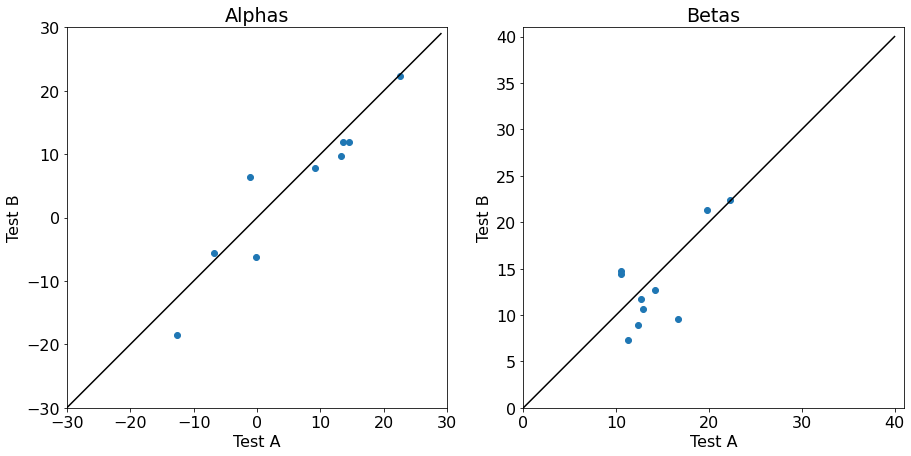

In [8]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(fit_alphas[:,0], fit_alphas[:,1],'o')
ax[0].plot(np.arange(-30,30), np.arange(-30,30),'k')
ax[0].set(xlim=(-30,30), ylim=(-30,30), title='Alphas', xlabel='Test A', ylabel='Test B')
ax[1].plot(fit_betas[:,0], fit_betas[:,1],'o')
ax[1].plot(np.arange(0,41), np.arange(0,41),'k')
ax[1].set(xlim=(0,41), ylim=(0,41), title='Betas', xlabel='Test A', ylabel='Test B')
plt.show()

# Logistic regression

## Logistic regression explanation 

Here we have an outcome variable (y) that is binary, and represents the number of times the test limb is selected. Therefore, it comes from a binomial distribution with a probability $p_i$ of choosing the test leg as more forward and n which is the number of trials: 

$$y_i \approx Binomial(n,p_i) $$

We assume that the target position variable has an impact on y. We also want to ensure that the start position does not have an effect on y. Therefore, our model is:

$$ logit(p_i) = \alpha + \beta_{start}*start + \beta_{trgt} * trgt  $$

The logit function is a link function that maps a parameter that is constrained between 0 and 1 ($p_i$) onto a linear model that can take on any real value. The logit function is defined as the log-odds:

$$ logit(p_i) = log \frac{p_i}{1-p_i}$$

The odds are the probability of an event occuring divided by the probability of the event not occuring. So we can write the model as such:

$$  log \frac{p_i}{1-p_i} = \alpha + \beta_{start}*start + \beta_{trgt} * trgt $$

So if we want the probability we have to solve for $p_i$

This is called the logistic function. Or sometimes called the inverse-logit function because it inverts the logit transform:
$$p_i = \frac{\exp^{\alpha + \beta_{start}*start + \beta_{trgt} * trgt}}{1+\exp^{\alpha + \beta_{start}*start + \beta_{trgt} * trgt}}$$

A note on interpretation: 
* In the log-odds scale, we are observing the parameters on a relative scale. On this scale, we can compare between parameter values. 
* To interpret the values in the real world, we have to transfer from the log odds scale to probability using the inverse logistic function. 
* Using the relative effects may exaggerate importance of predictor but are important for causal inference (for rare events, a small change in log-odds will result in large relative differences but small differences on the absolute scale).

## Potential confound 1: impact of movement direciton
Participants know which direction their leg is moving, this might affect their judgement of final position. 

**DAG**
![image.png](attachment:image.png)

If this is the case we should organize the data as follows: 
* MoveDir = coded as 1 (top down) or 0 (bottom up)
* Alpha = indexing variable for each subject
* TargetPos = coded as a continuous variable (i think), the other option would be to code it as a categorical variable like we do in the task itself.
* Response = the outcome variable where 1 is the judgement that the test limb is more forward

**Model:**
$$ L \approx Binomial(1,p) $$
$$ logit(p) = \alpha[SID] + \beta_{start}[MDidx] + \beta_{tp} * TrgtPos$$
$$ alpha \approx Normal(0,1) $$
$$ \beta_{start} \approx Normal(0,1) $$
$$ \beta_{end} \approx Normal(0,1) $$


In [18]:
move_dir_bool = np.array(DF.AllStarts.values > DF.AllStims.values, dtype=int)
y = np.array(DF.BinaryResponses,dtype=int)
x_stims = np.array(DF.AllStims.values, dtype=float)


In [19]:
#Build model using PM 
with pm.Model() as dirmoved_M:
#     alpha = pm.Normal("alpha", mu=0, sd=1, shape=len(np.unique(DF.SID)))
    B_sp = pm.Normal("B_sp", mu=0, sd=1, shape=2)
    B_tp = pm.Normal("B_tp", mu=0, sd=1)
    p = pm.Deterministic("p", pm.math.invlogit(B_sp[move_dir_bool] + 
                                               B_tp * x_stims))
    Lresp = pm.Binomial("Lresp", 1, p, observed=y)
    DM_prior = pm.sample_prior_predictive()
    DM_trace = pm.sample(1000, tune=1000)


You can find the C code in this temporary file: C:\Users\Jonathan\AppData\Local\Temp\theano_compilation_error_1575s63g


Exception: ('Compilation failed (return status=1): C:\\Users\\Jonathan\\AppData\\Local\\Temp\\cc32GGbP.s: Assembler messages:\r. C:\\Users\\Jonathan\\AppData\\Local\\Temp\\cc32GGbP.s:112: Error: invalid register for .seh_savexmm\r. ', 'FunctionGraph(Elemwise{eq,no_inplace}(p ~ Deterministic, <TensorType(int8, (True,))>))')

In [ ]:
#Check the priors
ax = az.plot_density(
    [logistic(DM_prior["alpha"]), logistic(DM_prior["B_sp"]), logistic(DM_prior["B_tp"])],
    group="prior",
    data_labels=['alpha', 'SP', 'TP'],
    point_estimate=None,
    )
plt.xlabel("Prior prob")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p")
plt.xlim(0,1)
plt.show()

In [ ]:
#Check the trace 
az.plot_trace(DM_trace)
plt.show()

In [ ]:
#Summary in log space
az.plot_forest(DM_trace, var_names=["alpha", "B_sp", "B_tp"], combined=True, hdi_prob=0.89)
plt.show()
az.summary(DM_trace, var_names=["alpha", "B_sp", "B_tp"])

In [ ]:
#Relative space 
ax = az.plot_forest(DM_trace, var_names=["B_sp"], combined=True)
ax[0].set_xlabel('Log-Odds',fontsize='x-large')
ax[0].set_yticklabels(['bottom-up','top-down'])
plt.show()
az.summary(DM_trace, var_names=["B_sp"])

#Top down minus bottom up
Differece = np.exp(DM_trace["B_sp"][:,1] - DM_trace["B_sp"][:,0]).mean().round(3)
print(Differece)

On a relative scale (log-odds), moving from the top down vs bottom up does not seem to have a large impact on the final decision. It does seem like when the leg moves from the top down (1) there is a reduced tendencay to say that limb is more forward compared to when the leg is moved from the bottom up. But this difference is not conclusive. 

So top down vs bottom up does not seem to have a large impact. But what about when comparing the movement directoin to the final position?

First, we note that the log odds estimate for final position has much greater certainty compared to the start position. The final position is also outside of the 95% probability interval for the start position.  

Top down multiplies the odds of saying the test limb is more forward by 0.81, a 19% reduction in odds. In other words, they are 19% less likely to say the the test limb is more forward when moving from the top down. 

In [ ]:
#Summary is probability space
ax = az.plot_forest(DM_trace, var_names=["B_sp"], combined=True, transform=logistic)
ax[0].set_xlabel('P(test more forward)',fontsize='x-large')
ax[0].set_yticklabels(['bottom-up','top-down'])
plt.axvline(0.5,c='k',ls='--')
plt.show()
(logistic(DM_trace["B_sp"][:,1]) - logistic(DM_trace["B_sp"][:,0])).mean().round(3)

In [ ]:
with dirmoved_M:
    DMpost = pm.sample_posterior_predictive(DM_trace, var_names=["B_sp","B_tp"])
    
az.plot_posterior(logistic(DMpost["B_sp"][:,1]) - logistic(DM_trace["B_sp"][:,0]),kind='hist',rope=[-0.05, 0.05])
plt.title('Movement Direction Contrast')
plt.xlabel('P_test')
plt.show()

In [ ]:
az.plot_posterior(logistic(DMpost["B_tp"]) - logistic(DMpost["B_sp"])[:,0], 
                  kind='hist', rope=(-0.05, 0.05))
plt.show()

**Interpretation:** When the target limb is moving from the top down, they are more likely than chance to say that the moving limb is more behind. 

When the target limb is moved from the bottom up, individuals are slightly more likely to say that the moving limb is more forward. 